# This is a notebook which describes Amoeba, a code which aims to model Quasar variability modularly.

It is modular in the sense that components may be added or removed and the full model can be built up from pieces. Not all AGN exhibit the same features, and this should be reflected within the model. Please contact Henry Best at HBest@gradcenter.cuny.edu for assistance / bug reports.

At time of writing this notebook, the accretion disk object with lamp post contributions are functional. The inclusion of BLR scattering + contribution is in progress.

Dependencies: Numpy, Astropy, Scipy, Matplotlib, skimage

Also: An external microlensing magnification map, which may be downloaded from the GERLUMPH database (https://gerlumph.swin.edu.au)


For GR ray tracing: Sim5




In [12]:
import numpy as np
import numpy.random as random
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.nddata import block_reduce
from scipy import signal
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import sys
import time as supertime
sys.path.append("../amoeba/Classes/")
sys.path.append("../amoeba/Util/")
# plt.style.use("plot_style_large_font.txt")
# import QuasarModelFunctions as QMF
import amoeba
# example_disk_path = '../SampleDisks/RayTrace.fits'
example_mag_map_path = "../../mapA.fits"# Insert a path to a magnification map (download seperate)
convolved_path = '../../mapA_convolvedR0=7.94e+14_cm.fits'

# PLOT SETTINGS
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.labelsize"] = BIGGER_SIZE
plt.rcParams["savefig.dpi"] = 600
plt.rcParams["savefig.bbox"] = "tight"

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in microlensing map

Text(0.5, 1.0, 'Convolved Microlensing Map')

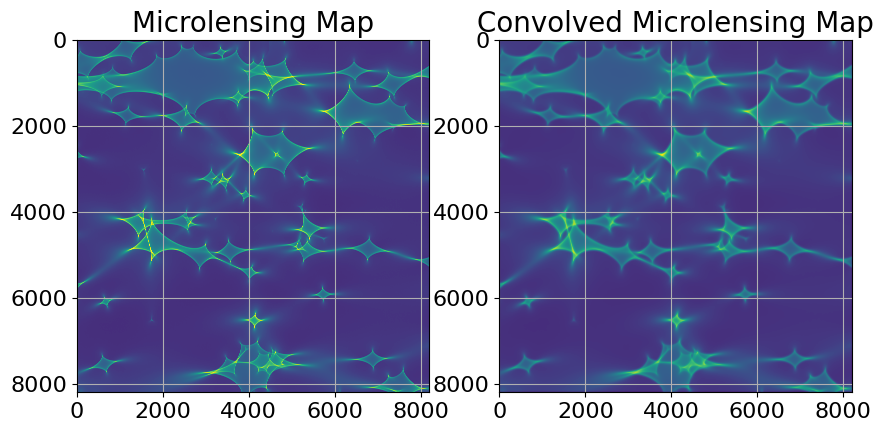

In [14]:
from astropy.visualization import simple_norm
hdul = fits.open(example_mag_map_path)
hdul0 = hdul[0]
hdul1 = fits.open(convolved_path)
hdul10 = hdul1[0]
mag_map_num_pix = hdul0.shape[0]
norm = simple_norm(hdul0.data, stretch ='asinh', asinh_a=0.2, vmin=0, vmax=20)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(hdul0.data, cmap='viridis', norm=norm)
ax[0].grid();
# ax[0].set_colorbar();
# simple_norm?
ax[0].set_title("Microlensing Map")

ax[1].imshow(hdul10.data, cmap='viridis', norm=norm)
ax[1].grid();
# ax[1].set_colorbar();
# simple_norm?
ax[1].set_title("Convolved Microlensing Map")

We will go down the list on the file QuasarModelFunctions, which hosts a majority of the code. First we will look at the dependence spin has on the ISCO, the innermost stable circular orbit within the Kerr metric.

### Dependence of spin on ISCO

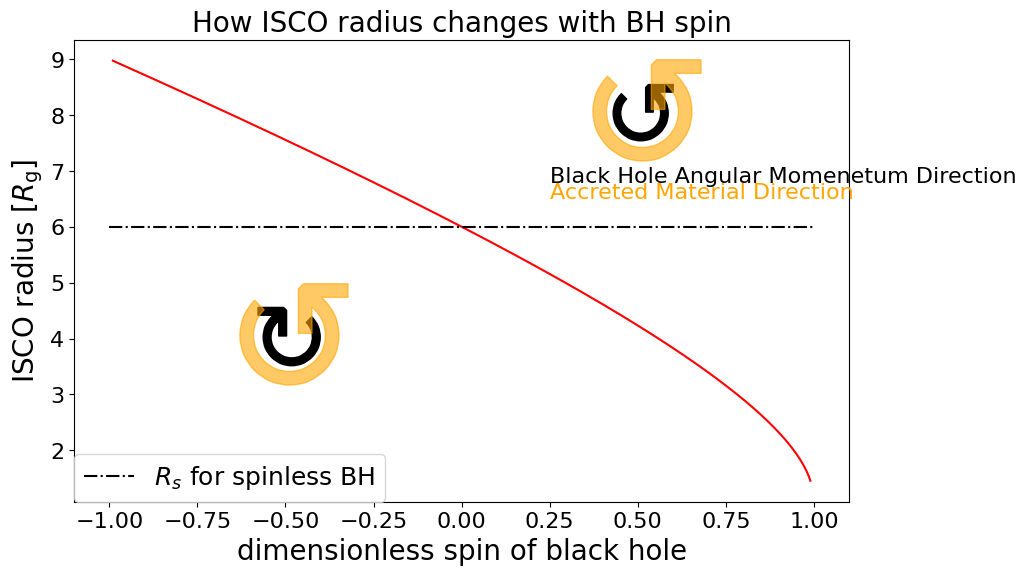

In [15]:
import util
from matplotlib.patches import Circle

time_initial = supertime.time()
spins = np.linspace(-0.99, 0.99, 500)
r_isco = np.array([util.convert_spin_to_isco_radius(s) for s in spins])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spins, r_isco, color='r')
ax.set_xlabel("dimensionless spin of black hole")
ax.set_ylabel(r"ISCO radius [$R_{\rm g}$]")
ax.plot([-1, 1], [6,6], '-.', color='black',label='$R_s$ for spinless BH')
ax.plot([0.5],[8],color='k', ls='--', alpha=1,marker=r'$\circlearrowleft$',ms=50)
ax.plot([0.5],[8],color='orange', ls='--', alpha=0.6,marker=r'$\circlearrowleft$',ms=90)

ax.plot([-0.5],[4],color='k', ls='--', alpha=1,marker=r'$\circlearrowright$',ms=50)
ax.plot([-0.5],[4],color='orange', ls='--', alpha=0.6,marker=r'$\circlearrowleft$',ms=90)
ax.text(0.25, 6.8, 'Black Hole Angular Momenetum Direction', color='k')

ax.text(0.25, 6.5, 'Accreted Material Direction', color='orange')


# Add clockwise circle with arrow
# circle2 = Circle((0.5, 0.5), 0.2, fill=False)
# ax.add_patch(circle2)
# ax.quiver(0.5, 0.5, 0, -0.1, angles='xy', scale_units='xy', scale=1, color='blue')
plt.title("How ISCO radius changes with BH spin")
plt.legend(loc=(0,0))
plt.show()

The horizontal line represents the Schwarzschild case for a spinless black hole. Negative values of spin represent a black hole with angular momentum in the opposite direction with respect to the accreted material, while positive values of spin represent alligned angular momentum

### Conversion between Eddington rate and accreted mass

Next is the convenience function "EddingtonRatioToMDot", which calculates the accreted material in physical units under the assumption of a specified Eddington ratio with respect to the Eddington luminosity.

**The Eddington luminosity is the theoretical limit which balances out gravitational pull against radiation pressure assuming protons are infalling via Bondi accretion.** It creates a convenient metric to describe accretion, but this is not a true limit. 

In [16]:
BHmass = 10 ** 8.0 * const.M_sun.to(u.kg) # 10^8 solar mass BH
eddingtons = 0.15 # eddington ratio
# accreted_material = QMF.EddingtonRatioToMDot(BHmass, eddingtons)
accreted_material = util.convert_eddington_ratio_to_accreted_mass(BHmass, eddingtons)


print("Black hole mass = ", BHmass)
print("Eddington ratio = ", eddingtons)
print("Accreted material = ", accreted_material)
print("or alternatively,", (accreted_material/const.M_sun.to(u.kg)*u.yr.to(u.s)).value, "M_sun / year")

Black hole mass =  1.988409870698051e+38 kg
Eddington ratio =  0.15
Accreted material =  2.0980104642293759e+21 kg / s
or alternatively, 0.0332970460475143 M_sun / year


We see that about 1/3rd of a solar mass is required to be accreted per year to power the accretion disk at 15% of the Eddington limit for a $10^{8}$ solar mass black hole.

### Radial temperature profiles for different disk models

Radial temperature profiles can be constructed using the "AccDiskTemp" function. The basic temperature profile is the Shakura-Sunyaev thin disk profile (Shakura+Sunyaev, 1973), and the function provided allows us to smoothly transition to both irradiated disk models (Cackett+ 2007) and disk wind models (Sun+ 2018). By default, a thin disk profile will be constructed. There are a few terms here, so I will outline them now.

 - $R$ is the position at which we are evaluating the temperature, regardless of the model.

 - $R_{min}$ is the inner bound of the accretion disk, usually taken to be the ISCO.

 - $M$ is the mass of the central black hole.

 - $M_{acc}$ is the accreted mass through the accretion disk.

Each of these terms are always required, and are assumed in MKS units.

Terms for the **irradiated disk model** are:

 - `corona_height` ($h_c$), the height of the central lamp post irradiating the accretion disk. This is assumed to be input in gravitational radii ($R_g$).

 - `albedo`, the reflectivity of the accretion disk with respect to irradiating x-ray sources. This is a dimensionless value between 0 and 1, where 0 is perfect absorption (leading to heating up the disk), and 1 is perfect reflection (no heat energy is transfered to the disk).

 - `eta`, the efficiency of the x-ray emitter with respect to the Eddington luminosity. This parameter is essentially the Eddington ratio for the corona.

Terms for the disk wind model are:

 - `beta`, the strength of the wind. In general, stronger winds are believed to remove material from the accreiton disk causing higher accretion rates further out in the disk than expected. 

 - `generic_beta`, a toggle if the user instead wishes to use beta as the asymptotic temperature slope instead of the physically motivated wind parameter.

One last convenience term is "eddingtons", which if given a value, will calculate the required accreted material in order to produce this Eddington ratio.


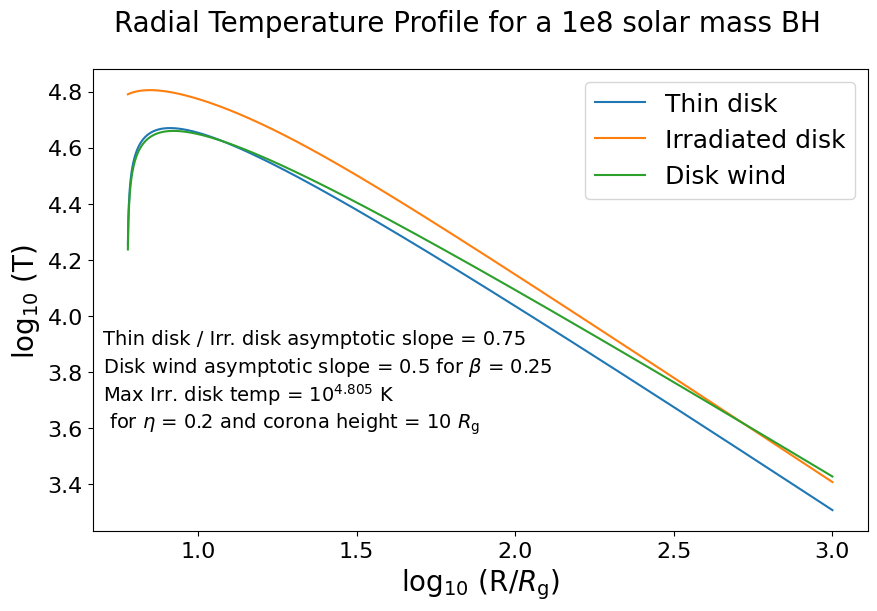

In [17]:
grav_rad = util.calculate_gravitational_radius(BHmass)
radii = np.linspace(1, 1000, 50000)
ISCO = 6 * grav_rad
beta = 0.25
lamp_height = 10
eta = 0.2

thindiskprofile = util.accretion_disk_temperature(radii*grav_rad, ISCO, BHmass,eddington_ratio=0.15)     
sample_irr_disk =  util.accretion_disk_temperature(radii*grav_rad, ISCO, BHmass, 
                                  corona_height=lamp_height, albedo=0, eta_x_rays=eta, eddington_ratio=0.15)
sample_diskwind =  util.accretion_disk_temperature(radii*grav_rad, ISCO, BHmass, 
                                  beta=beta, eddington_ratio=0.15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10(radii), np.log10(thindiskprofile), label="Thin disk")
ax.plot(np.log10(radii), np.log10(sample_irr_disk), label="Irradiated disk")
ax.plot(np.log10(radii), np.log10(sample_diskwind), label="Disk wind")
ax.set_xlabel(r"log$_{10}$ (R/$R_{\rm g}$)")
ax.set_ylabel(r"log$_{10}$ (T)")
ax.text(0.7, 3.9, "Thin disk / Irr. disk asymptotic slope = 0.75", fontsize=14)
ax.text(0.7, 3.8, r"Disk wind asymptotic slope = "+str((3 - 4 * beta)/4)+r" for $\beta$ = "+str(beta), fontsize=14)
ax.text(0.7, 3.6, r"Max Irr. disk temp = 10$^{"+str(np.log10(np.max((sample_irr_disk))))[:5]+r"}$ K"+"\n"+r" for $\eta$ = "+str(eta)+ " and corona height = "+ str(lamp_height) +r" $R_{\rm g}$", fontsize=14)
fig.suptitle("Radial Temperature Profile for a 1e8 solar mass BH")
plt.legend()
plt.show()

Due to the amount of parameters, this profile is quite flexible. The calculation is vectorized leading to rapid calculations even for many points.

### Connecting temperature and luminosity

The connection between temperature and luminosity is assumed to be black body radiation, given through the Planck formula. The function "PlanckLaw" takes two inputs, a temperature in Kelvins, and a wavelength which is assumed to be in nanometers. This choice was made as it's convenient for UV, optical, and IR emissions, where the accretion disk tends to dominate the quasar's power.

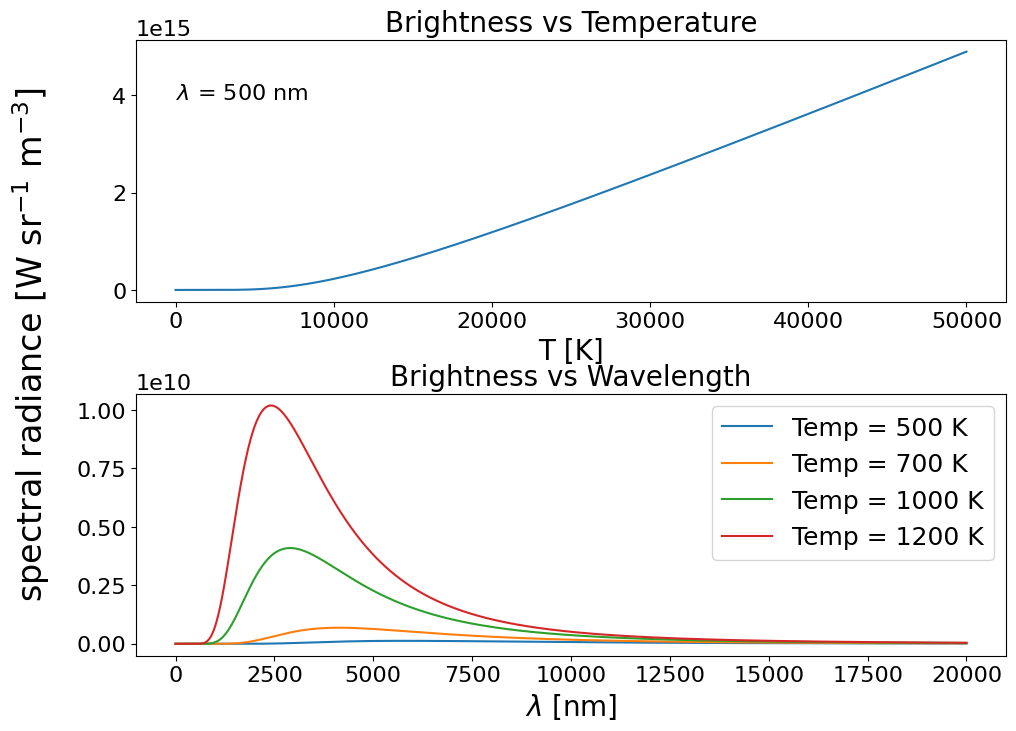

In [18]:
const_lam = 500
const_temp = 1200
maxlam = 20000

temperatures = np.linspace(1, 50000, int(1e6))
wavelengths = np.linspace(1, maxlam, int(1e6))
brightnesses = util.planck_law(temperatures, const_lam)
spectra500 = util.planck_law(500, wavelengths)
spectra700 = util.planck_law(700, wavelengths)
spectra1000 = util.planck_law(1000, wavelengths)
spectraconst = util.planck_law(const_temp, wavelengths)

fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(temperatures, brightnesses)
ax[1].plot(wavelengths, spectra500, label='Temp = 500 K')
ax[1].plot(wavelengths, spectra700, label='Temp = 700 K')
ax[1].plot(wavelengths, spectra1000, label='Temp = 1000 K')
ax[1].plot(wavelengths, spectraconst, label='Temp = '+str(const_temp)+' K')
# ax[1].set_ylim(0, np.max(spectra1000)/2)

ax[0].set_xlabel("T [K]")
ax[1].set_xlabel(r"$\lambda$ [nm]")
ax[0].text(0, 0.8*np.max(brightnesses), r"$\lambda$ = "+str(const_lam)+" nm", fontsize=16)
#ax[1].text(0.5*maxlam, 0.8*np.max(spectra1000), "Constant temp = "+str(const_temp)+" K", fontsize=16)
ax[1].legend()
fig.supylabel("spectral radiance [W sr$^{-1}$ m$^{-3}$]", fontsize=24)
plt.subplots_adjust(hspace=0.35, right=0.85)
ax[0].set_title("Brightness vs Temperature")
ax[1].set_title("Brightness vs Wavelength")

plt.show()

Note that these axes are on large scales, due to the radiance being calculated in MKS units. This is a flux density that passes through some solid angle. True fluxes will appear smaller as these are expressed per meter, as opposed to per nanometer or angstrom.

### Brightness at different radii -- Radial surface brightness profile

Planck's law will usually be applied to the accretion disk temperature profile, so we can combine the two to create a radial surface birghtness profile.

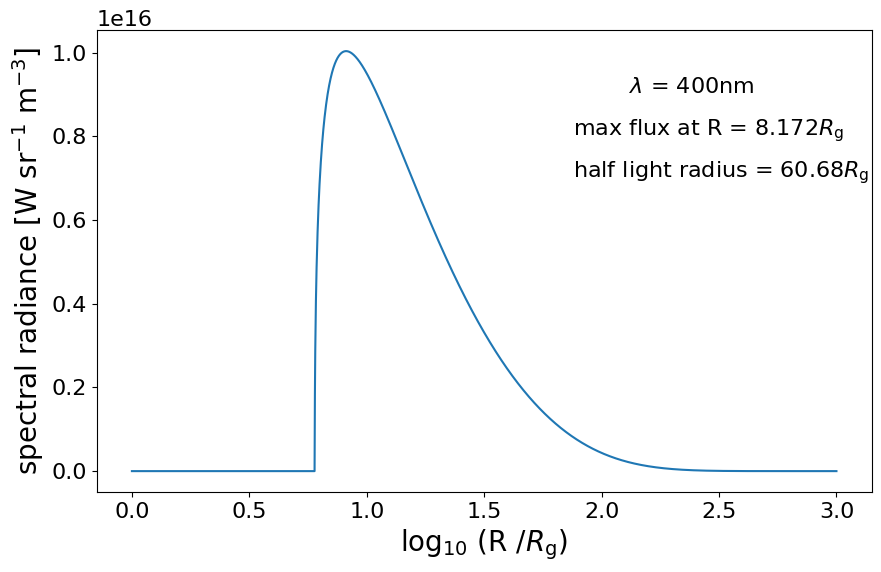

In [19]:
sim_wavelength = 400 #nm
temp_profile = thindiskprofile
sb_profile = util.planck_law(temp_profile, sim_wavelength)
half_rad = np.sum(radii*sb_profile) / 2
for kk in range(len(radii)):
    if np.sum(radii[:kk]*sb_profile[:kk]) > half_rad:
        index = kk
        break

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(radii), sb_profile)
ax.text(0.45*np.log10(len(radii)), 0.9*np.max(sb_profile), r"$\lambda$ = "+str(sim_wavelength)+r"nm", fontsize=16)
ax.text(0.4*np.log10(len(radii)), 0.8*np.max(sb_profile), r"max flux at R = "+str(radii[np.argmax(sb_profile)])[:5]+r"$R_{\rm g}$", fontsize=16)
ax.text(0.4*np.log10(len(radii)), 0.7*np.max(sb_profile), r"half light radius = "+str(radii[index])[:5]+r"$R_{\rm g}$", fontsize=16)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral radiance [W sr$^{-1}$ m$^{-3}$]")
plt.show()


The peak flux density will always peak at the point of maximum temperature, but the half light radius will depend on the wavelength evaluated at.

A value which is important for calculating the response of the disk by some external stimulus is the derivative of Planck's law. It is numerically calculated in the approximation that temperature is increased by 1 Kelvin, which is almost always a safe approximation for the effective temperatures of the accretion disk.

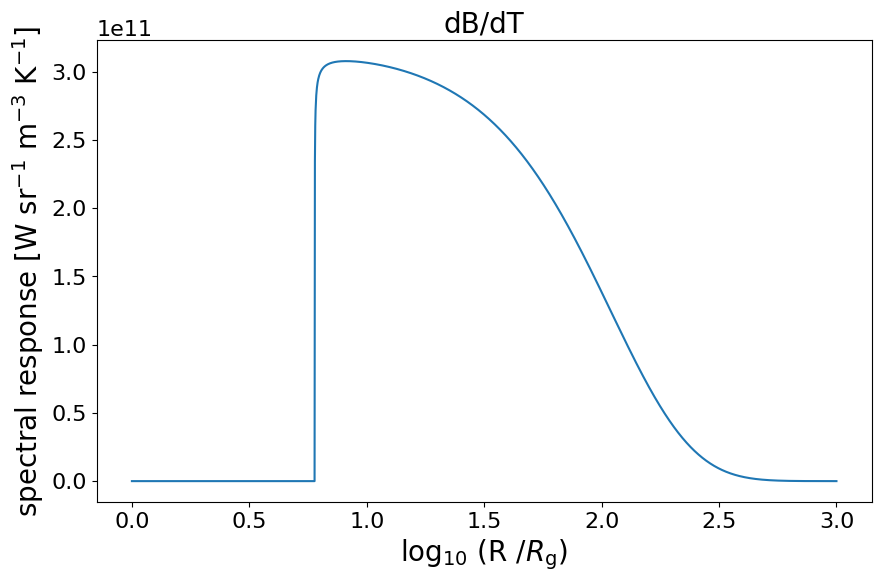

In [20]:
sim_wavelength = 400 #nm
temp_profile = thindiskprofile
sb_profile = util.planck_law_derivative(temp_profile, sim_wavelength)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(radii), sb_profile)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
ax.set_title("dB/dT")
plt.show()

It is immediately apparent that this curve is wider for accretion disks than the spectral radiance, and will lead to the structure of response functions later in this notebook.

A few functions for calculating distances in flat cosmology are included, such as angular diameter distance, angular diameter distance difference, and luminosity distance. One classic example is the turnover for angular diameter distance.

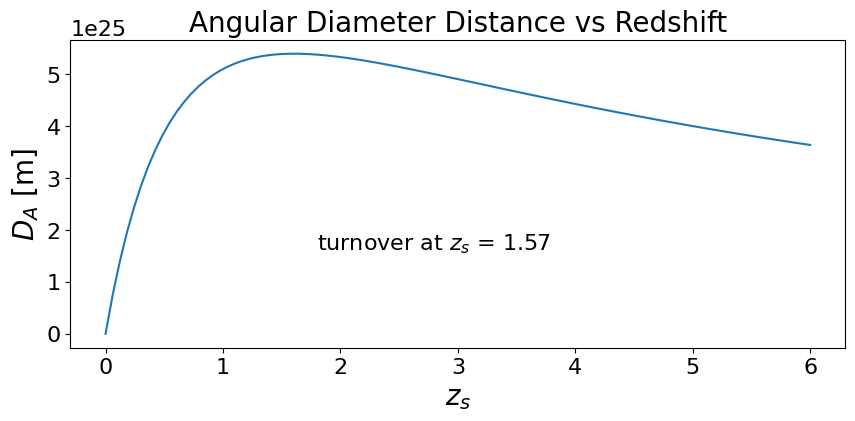

In [21]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)

redshifts = np.linspace(0, 6, 100)
ang_diameters = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_diameters[rs] = util.calculate_angular_diameter_distance(redshifts[rs], Om0 = Omega_0, little_h = little_h)

    
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(redshifts, ang_diameters)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("$D_A$ [m]")
ax.text(0.3*np.max(redshifts), 0.3*np.max(ang_diameters), r"turnover at $z_{s}$ = "+str(redshifts[np.argmax(ang_diameters)])[:4], fontsize=16)
ax.set_title("Angular Diameter Distance vs Redshift")
plt.show()
        

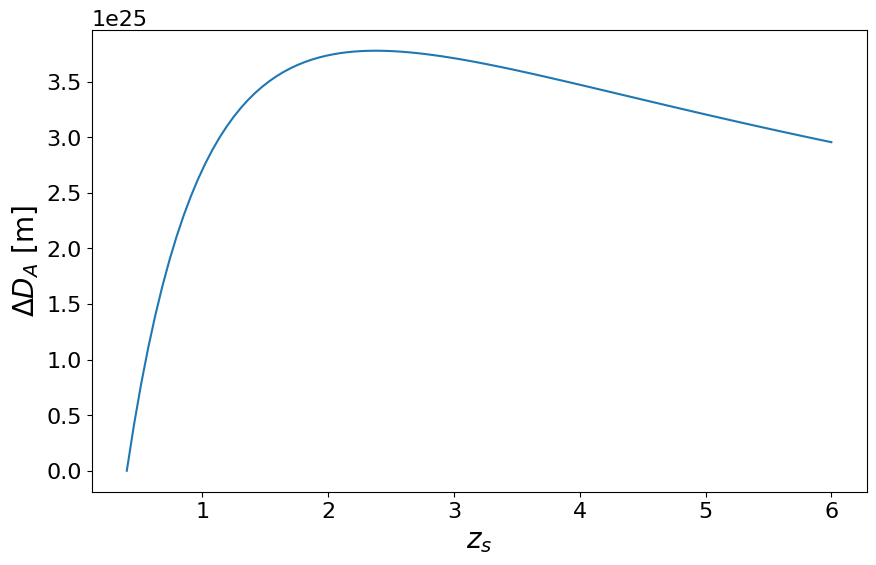

In [22]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)
z1 = 0.4

redshifts = np.linspace(z1, 6, 100)
ang_dia_diffs = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_dia_diffs[rs] = util.calculate_angular_diameter_distance_difference(z1, redshifts[rs], Om0 = Omega_0, little_h = little_h)

    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(redshifts, ang_dia_diffs)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("$\Delta D_A$ [m]")
plt.show()

Luminosity distances can be used to scale emission simulations to cosmological distances

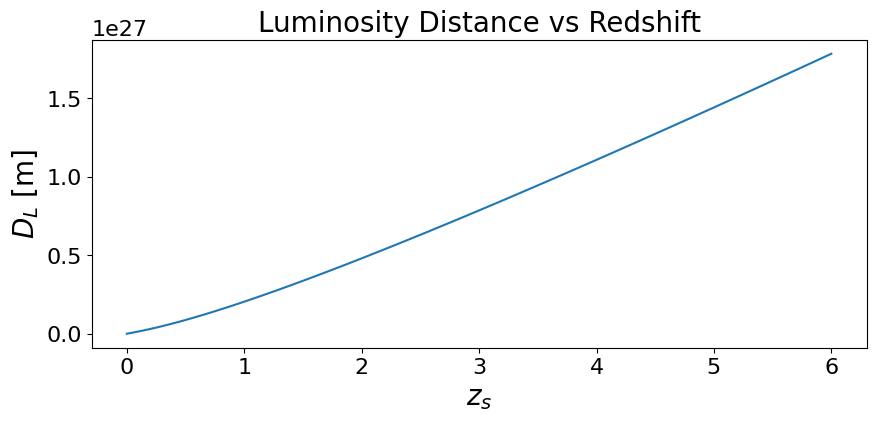

In [23]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)

redshifts = np.linspace(0, 6, 100)
lum_dist = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    lum_dist[rs] = util.calculate_luminosity_distance(redshifts[rs], Om0 = Omega_0, little_h = little_h)

    
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(redshifts, lum_dist)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("$D_L$ [m]")
ax.set_title("Luminosity Distance vs Redshift")
plt.show()

Unlike diameter distances, the luminosity distance does not have a turnover point.

An important quantity in microlensing is the Einstein radius, which depends on the lens and source positions. Cosmology also effects this as the angular diameter distances are used.

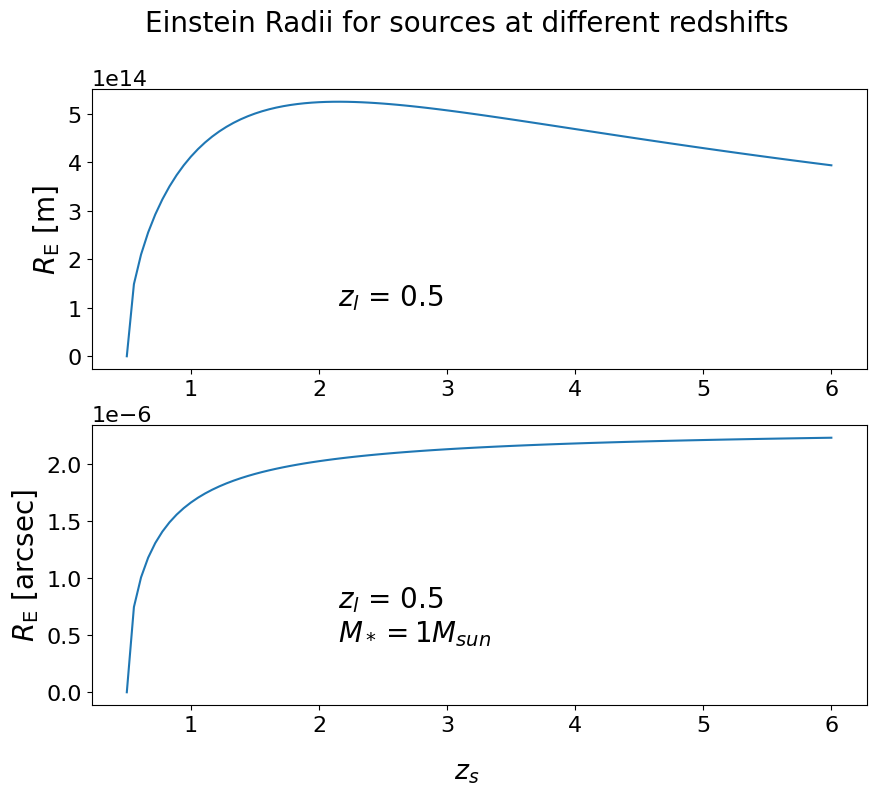

In [24]:
z_lens = 0.5
z_s = np.linspace(z_lens, 6, 100)
m_lens = 1*const.M_sun.to(u.kg)

ein_rad_m= np.zeros(np.shape(z_s))
ein_rad_ang= np.zeros(np.shape(z_s))
for rs in range(len(z_s)):
    ein_rad_m[rs] = util.calculate_einstein_radius_in_meters(z_lens, z_s[rs], mean_microlens_mass_in_kg=m_lens)
    ein_rad_ang[rs] =206265*util.calculate_angular_einstein_radius(redshift_lens=z_lens,
    redshift_source = z_s[rs],
    mean_microlens_mass_in_kg=m_lens,
    Om0=0.3,
    little_h=0.7,)
            # Note QMF.CalcRe() will calculate an angle in radians, so it must be multiplied by the distance
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(z_s, ein_rad_m)
ax[0].set_ylabel(r"$R_{\rm E}$ [m]")
ax[0].text(0.3 * (np.max(z_s)-np.min(z_s)) + np.min(z_s), 0.2 * np.max(ein_rad_m), r"$z_{l}$ = "+str(z_lens), fontsize=20)

ax[1].plot(z_s, ein_rad_ang)
fig.supxlabel(r"$z_{s}$")
ax[1].set_ylabel(r"$R_{\rm E}$ [arcsec]")
ax[1].text(0.3 * (np.max(z_s)-np.min(z_s)) + np.min(z_s), 0.2 * np.max(ein_rad_ang), r"$z_{l}$ = "+str(z_lens)+'\n$M_*=1 M_{sun}$', fontsize=20)
fig.suptitle("Einstein Radii for sources at different redshifts")
plt.show()
                

Note that the angular scales are so small -- ~1e-6 arcsec!

Like with other angular diameter distances, this experiences a turnover as well. **The Einstein radius determines the scale which microlensing probes most effectively at.**

We do not provide magnification maps in the source plane, so this must be obtained elsewhere through inverse ray shooting methods or other similar procedures. With the representative map of magnifications, we can explore the convolution between an accretion disk surface brightness image and the magnifications due to microlensing

Set up a generic surface brightness map

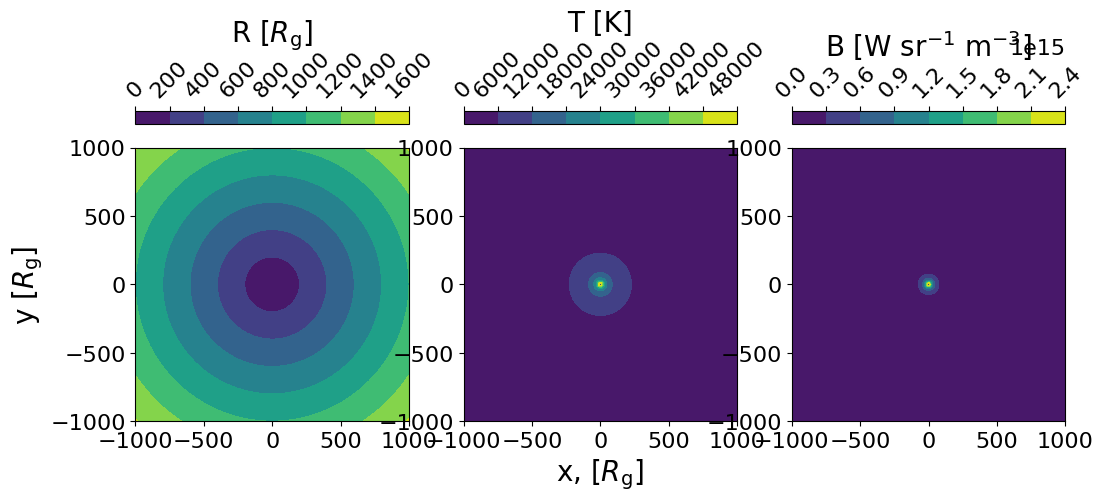

In [25]:
x = np.linspace(-1000, 1000, 2048)
y = np.linspace(-1000, 1000, 2048)
X, Y = np.meshgrid(x, y)
radii, phi_array=util.convert_cartesian_to_polar(X, Y)
mass = 10**8.0*const.M_sun.to(u.kg)
grav_rad = util.calculate_gravitational_radius(mass)
temp_map = util.accretion_disk_temperature(radius_in_meters=radii*grav_rad, min_radius_in_meters=6*grav_rad, mass_in_solar_masses=mass, eddington_ratio=0.15) # accretion of 7234 is overridden
sb_map = util.planck_law(temp_map, 600)

fig, ax = plt.subplots(1,3,figsize=(12, 6))
c1 = ax[0].contourf(X, Y, radii)
c2 = ax[1].contourf(X, Y, temp_map)
c3 = ax[2].contourf(X, Y, sb_map)
cbar1 = plt.colorbar(c1, ax=ax[0], location='top', label=r'R [$R_{\rm g}$]')
cbar2 = plt.colorbar(c2, ax=ax[1], location='top', label='T [K]')
cbar3 = plt.colorbar(c3, ax=ax[2], location='top', label=r'B [W sr$^{-1}$ m$^{-3}$]')
cbar1.ax.tick_params(rotation=45)
cbar2.ax.tick_params(rotation=45)
cbar3.ax.tick_params(rotation=45)
ax[0].set_ylabel(r"y [$R_{\rm g}$]")
ax[1].set_xlabel(r"x, [$R_{\rm g}$]")
for axis in ax:
    axis.set_aspect(1)
plt.show()

The first image is just the radial distances to all positions on the source plane. The second image shows a few contours of temperature, while the third image shows the spectral radiance of the disk around 600 nm which is proportional to observed flux.

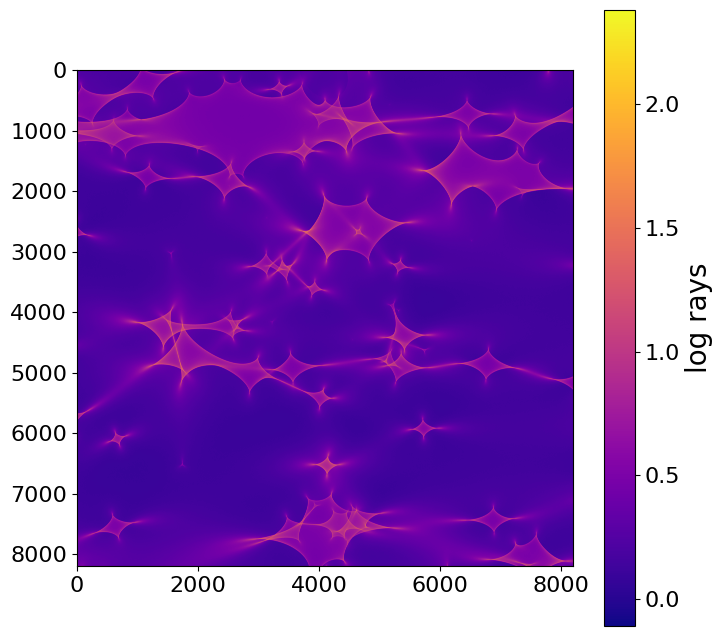

In [26]:
mag_map_path = example_mag_map_path

with fits.open(mag_map_path) as f:
    mag_map = f[0].data
mag_map_num_pix = mag_map.shape[0]
fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.imshow(np.log10(mag_map), cmap="plasma")
cbar = plt.colorbar(conts, ax=ax, label="log rays")
# magnification map image, contours are extremely thin so it's difficult to see by eye except on log scale
plt.show()

To perform the convolution, we should store our accretion disk and magnificaiton maps in their respective classes. The convolution may then be done using the MagnificationMap.convolve_with_flux_projection method. More information on classes follows.

The funciton "ConvolveMaps" can be used to make the convolution between the magnification map and the surface brightness map. Inputs are as follows:

MagMap is the magnification map

disk is the image of the disk in the source plane

redshift_lens is the redshift of the microlenses 

redshift_source is the redshift of the source

mass_exp is log_10(M_BH/M_sun)

mlens is the microlens mass

nmapERs is the number of Einstein radii the magnification map covers on each side

numGRs is the number of gravitational radii the disk image is

rotation is an angular rotation given to the accretion disk in the source plane, especially interesting for inclined accretion disks (in degrees)

verbose is a toggle to keep track of each step in the process

returnmag2d allows the magnificaiton map to be returned as well

In [27]:
z_s = 1.29
z_l = 0.317
from amoeba.Classes.accretion_disk import AccretionDisk
from amoeba.Classes.magnification_map import MagnificationMap

Disk = AccretionDisk(
    smbh_mass_exp=8.0,
    redshift_source=z_s,
    inclination_angle=0,
    corona_height=lamp_height,
    temp_array=temp_map,
    phi_array=phi_array,
    g_array=np.ones(np.shape(temp_map)),
    radii_array=radii,
    height_array=np.zeros(np.shape(radii)),
)

disk_projection = Disk.calculate_surface_intensity_map(600)

MagMap = MagnificationMap(
    redshift_source=z_s,
    redshift_lens=z_l,
    magnification_array=mag_map,
    convergence=0.6,
    shear=0.7,
    mean_microlens_mass_in_kg=0.3* const.M_sun.to(u.kg),
    total_microlens_einstein_radii=20
)


convolution = MagMap.convolve_with_flux_projection(disk_projection)

Pixel Ratio:  0.17292372744957765


The pixel sizes are :  833903381599.881 m
The pixel shift due to the convolution is :  177 pixels


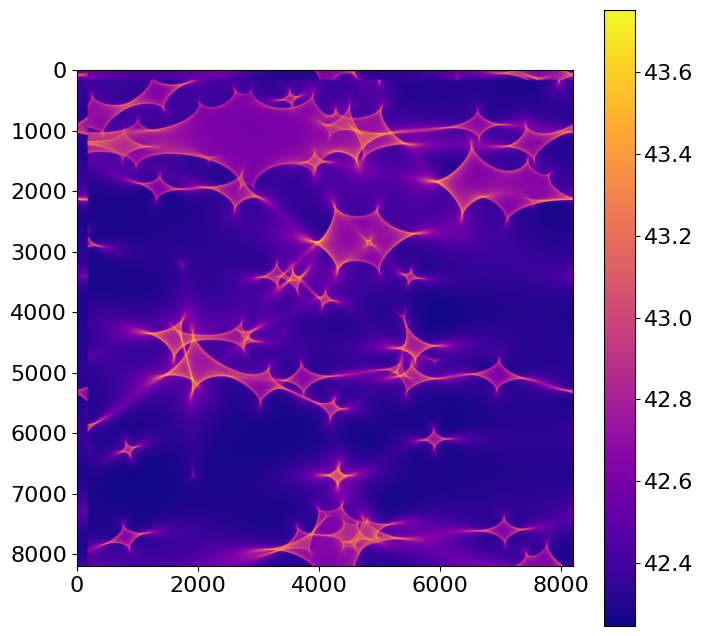

In [28]:
convolved_flux_map = convolution.magnification_array

print("The pixel sizes are : ", convolution.pixel_size, "m")
print("The pixel shift due to the convolution is : ", convolution.pixel_shift, "pixels")
fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.imshow(np.log10(convolved_flux_map), cmap="plasma")
cbar = plt.colorbar(conts, ax=ax)

plt.show()

Depending on the size of the accretion disk, there is a region near the edges we must not use to avoid convolution artifacts. 

From this map, we can pull random light curves using PullLC function.

96.60808259182056
96.60808259182056
96.60808259182056
96.60808259182056
96.60808259182056
96.60808259182056
96.60808259182056


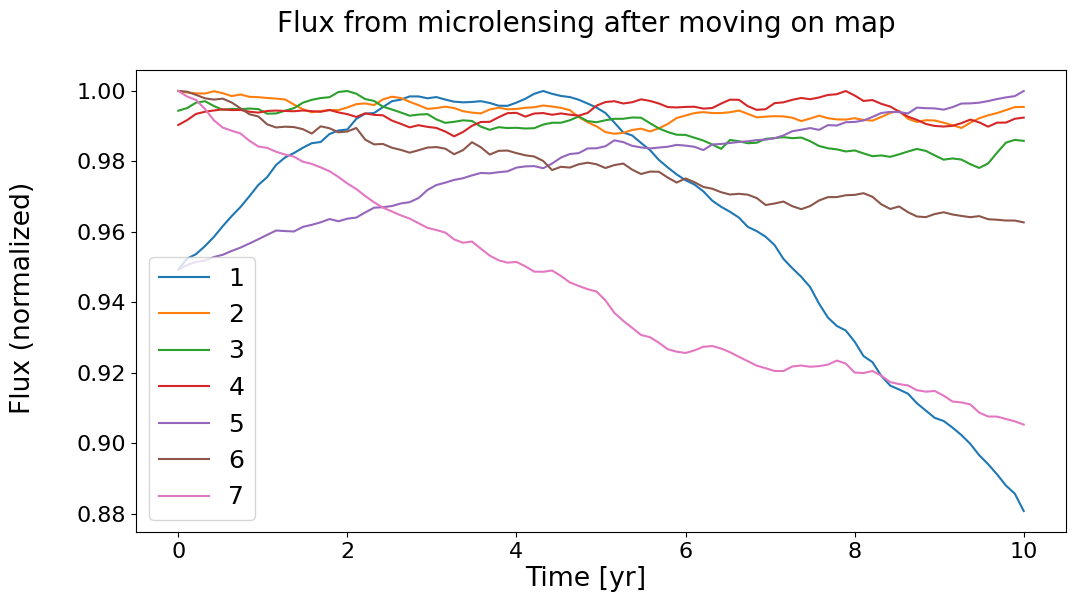

In [29]:
v_trans = 250  # km/s in source plane
time = 10 # years
np.random.seed(2)  # for reproducibility

LCs = []
tracks = []

for jj in range(7):
    curve, tracks_x, tracks_y = convolution.pull_light_curve(
        v_trans, time, return_track_coords=True
    )
    LCs.append(curve)
    tracks.append([tracks_x, tracks_y])

fig, ax = plt.subplots(figsize=(12, 6))
for jj in range(len(LCs)):
    ax.plot(np.linspace(0,10, len(LCs[jj])), LCs[jj]/np.max(LCs[jj]), label=str(jj + 1))
fig.supxlabel("Time [yr]")
fig.supylabel("Flux (normalized)")
fig.suptitle("Flux from microlensing after moving on map")
ax.legend()
plt.show()

### Show source track on microlensing maps -- the transverse velocity means that we overlap with different caustics as a function of time

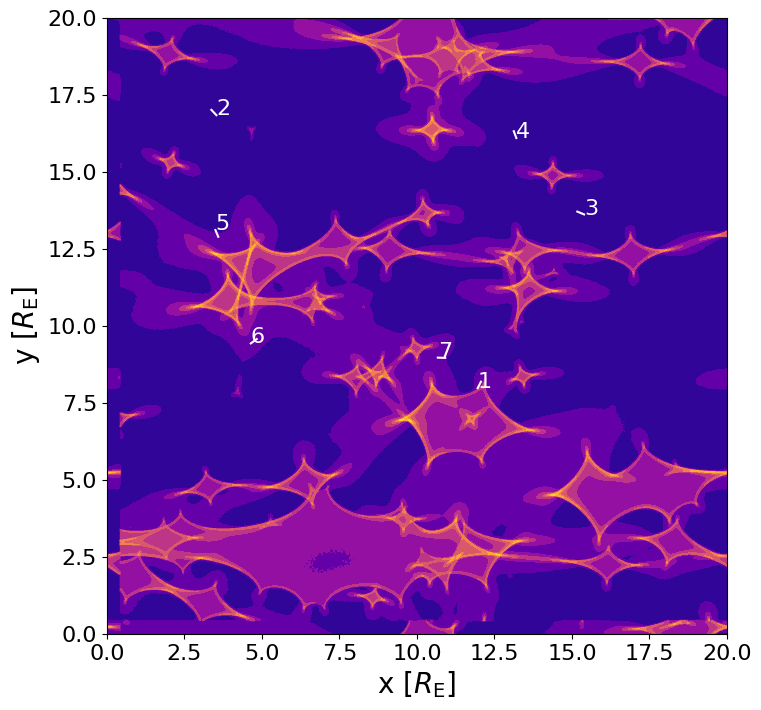

In [30]:
x = np.linspace(0, 20, convolution.magnification_array.shape[0])  # Convert axes to units R_g
y = np.linspace(0, 20, convolution.magnification_array.shape[0])
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Y, np.log10(convolution.magnification_array), cmap="plasma")
for jj in range(len(tracks)):
    ax.plot(tracks[jj][1] / 400, tracks[jj][0] / 400, color="white")
    ax.text(
        tracks[jj][1][0] / 400,
        tracks[jj][0][0] / 400,
        str(jj + 1),
        color="white",
        fontsize=16,
    )
ax.set_xlabel(r"x [$R_{\rm E}$]")
ax.set_ylabel(r"y [$R_{\rm E}$]")

plt.show()

For reproducability, a random seed may be set.

### Transfer Functions

Going back to the accretion disk itself, the lamp post model predicts time lags to be dominated by the **light travel time between the x-ray source and the accretion disk**. This may be extended to any source of additional flux which may heat up the accretion disk, i.e. a magnetic recombination flare in plasma, an unstable jet base, etc.

The function `calculate_time_lag_array` allows for the creation of a **time lag map from any point above the accretion disk to the accretion disk**.

The arguments are as follows:

`radii_array` is a 2d array in gravitational radii.

`phi_array` is a 2d array of azimuth angles defined such that the negative y axis is toward the observer.

`inclination_angle` is the inclination of the disk in degrees.

`corona_height` is the height of the lamppost in gravitational radii.

`axis_offset_in_gravitational_radii` is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

`angle_offset_in_degrees` is an azimuth offset for the lamppost's position.

`height_array` is a 2d array of heights representing where we are computing the time lag to.

(2048, 2048)


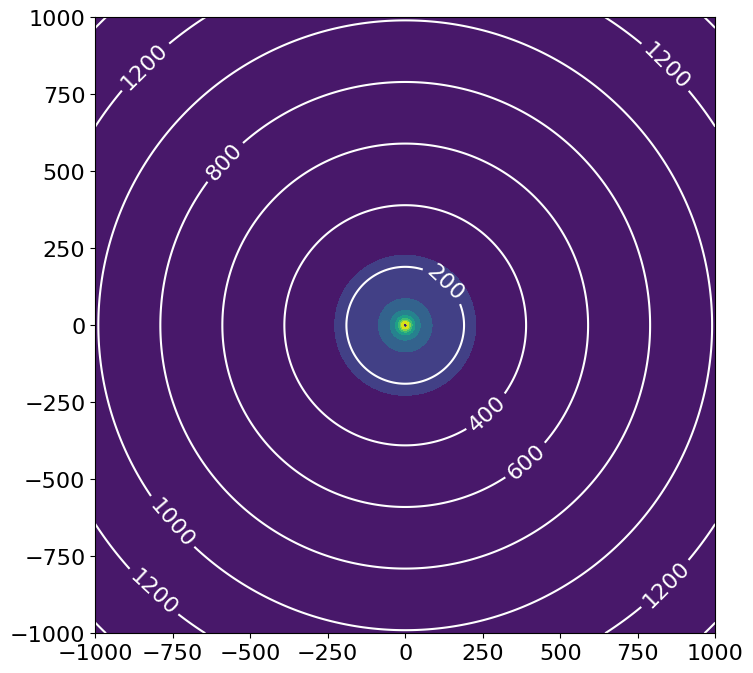

In [31]:
time_delays = util.calculate_time_lag_array(
    radii_array = radii,
    phi_array = phi_array,
    inclination_angle = 0,
    corona_height=10,
    axis_offset_in_gravitational_radii=0,
    angle_offset_in_degrees=45,
)  # note axis offset!

print(np.shape(phi_array))
x = np.linspace(-1000, 1000, 2048)
y = np.linspace(-1000, 1000, 2048)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Y, temp_map)
delays = ax.contour(X, Y, time_delays, colors="white")
plt.clabel(delays, inline=1, fontsize=16)
plt.show()

specifying the redshift is important because all time scales, including these time delays, will get scaled.

`calculate_geometric_disk_factor` is a function which calculates the geometric coefficient in the lamppost model. This is defined as $$\frac{(1 - A) \cos(\theta_x)} {(4 * \pi * \sigma_{sb} * R_{lamppost}^{2})}.$$ If we assume the same functional form which connects the lamp post to the heating of the disk, this term can be extended to be used with any other flaring event beyond the lamp post model including those described in the time delay map description above.

This function takes the following arguments:

`temp_array` is the temperature of the accretion disk at all positions in Kelvins.

`radii_array` is the radius in gravitational radii.

`phi_array` is the azimuth angle as described previously.

`smbh_mass_exponent` is the log_10(M/M_{sun}).

`corona_height` is the height of the lamppost in gravitational radii.

`axis_offset_in_gravitational_radii` is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

`angle_offset_in_degrees` is an azimuth offset for the lamppost's position.

`height_array` is a 2d array of heights representing where we are computing the time lag to. Note this is still experimental at this point!

`albedo_array` is a 2d array of albedo values, allowing for non-uniform absorption by the accretion disk.

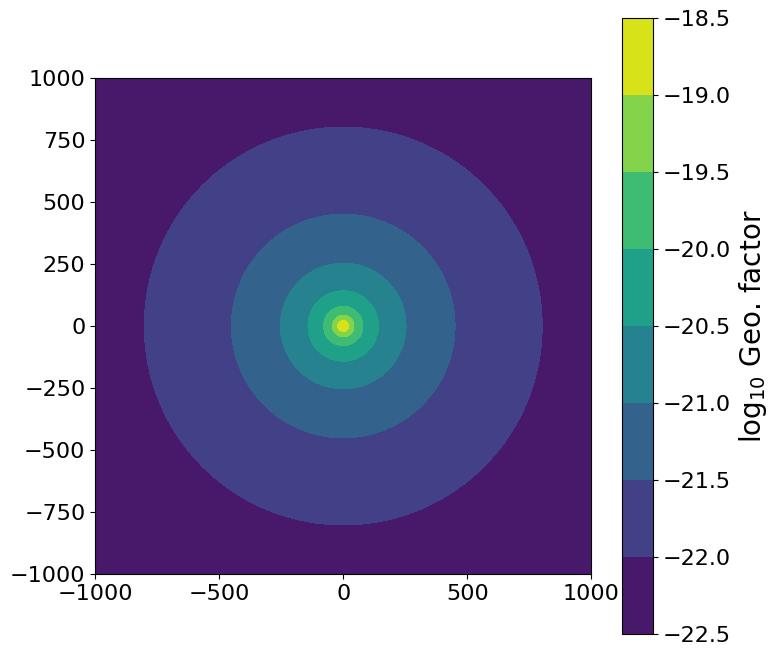

In [32]:
disk_factor = util.calculate_geometric_disk_factor(
    temp_array = temp_map,
    radii_array = radii,
    phi_array = phi_array,
    smbh_mass_exponent = 8.0,
    corona_height = 10,
    axis_offset_in_gravitational_radii = 0,
    angle_offset_in_degrees = 45,
)
fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.contourf(X, Y, np.log10(disk_factor.value))
cbar = plt.colorbar(conts, ax=ax, label=r"log$_{10}$ Geo. factor")
ax.set_aspect(1)
plt.show()

For the case of the lamp post illuminator, the geometric factor above scales the x-ray luminosity. Under the assumption any other illuminator acts the same way, the geometric factor should remain identical and this can be used at any other position.

The function `calculate_dt_dlx` calculates the rate of change in temperature with respect to illumination from the x-ray source

its arguments are identical to calculate_geometric_disk_factor.

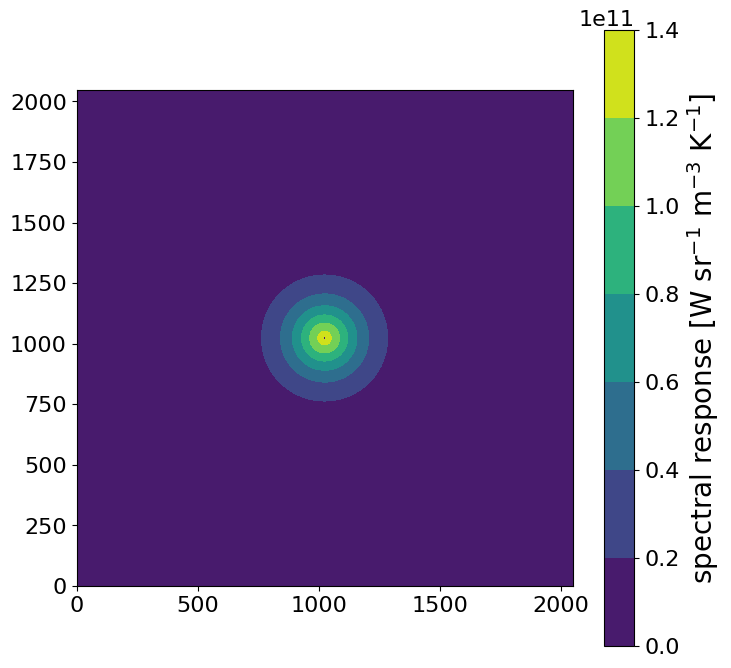

In [33]:
lam = 500
disk_deriv = util.planck_law_derivative(temp_map, lam)

fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.contourf(disk_deriv)
plt.colorbar(conts, ax=ax, label="spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
ax.set_aspect(1)
plt.show()

These values look high, but the geometric factor hasn't been taken into account yet, nor the power of the illuminating source.

Combining all of the above, we can construct the transfer function which connects the driving source to the accretion disk's response. This is the kernel between some impulse at a position above the disk and the disk's response, and is wavelength dependent.

`construct_accretion_disk_transfer_function` has the following arguments:

`rest_wavelength_in_nm` is the wavelength in nanometers which we are computing the transfer function of.

`temp_array`, `radii_array`, `phi_array` are the temperature, radii, and azimuths of the accretion disk, respectively.

`g_array` is a 2d array of relativistic redshifts.

`inclination_angle` is the inclination of the accretion disk in degrees.

`corona_height` is the height of the lamppost in gravitational radii.

`axis_offset_in_gravitational_radii` is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

`angle_offset_in_degrees` is an azimuth offset for the lamppost's position.

`height_array` is a 2d array of heights representing where we are computing the time lag to. Note this is still experimental at this point!

`albedo_array` is a 2d array of albedo values, allowing for non-uniform absorption by the accretion disk.

`return_response_array_and_lags` is a boolean to return the 2d distributions of the surface response and the time delays.

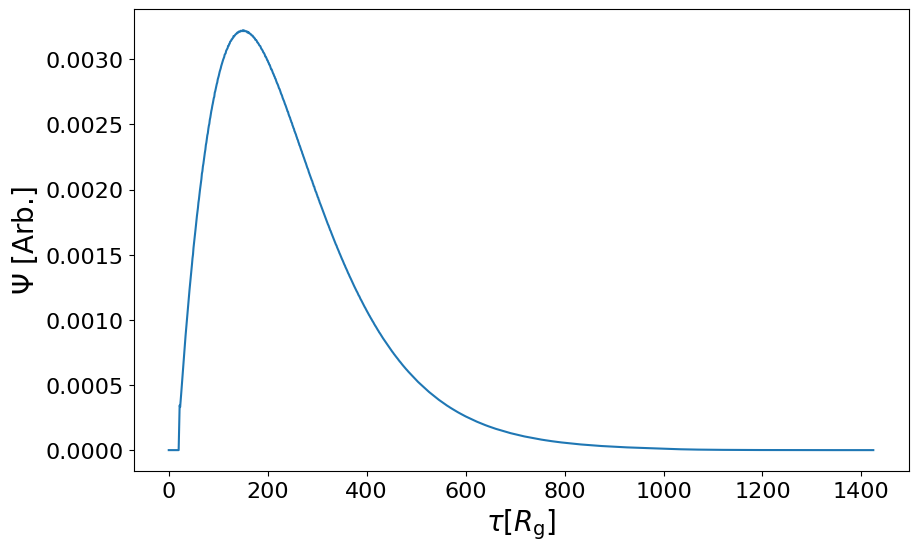

In [34]:
cheight = 10

basic_transfer_function = util.construct_accretion_disk_transfer_function(
    rest_wavelength_in_nm = 500, temp_array=temp_map, radii_array=radii, 
    phi_array=phi_array, g_array=np.ones(np.shape(radii)), 
    inclination_angle=0, 
    smbh_mass_exponent=8,
    corona_height=cheight,
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(basic_transfer_function)
ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi$ [Arb.]")
plt.show()

The transfer function generally features an initial time lag, which depends on how far light must travel down to the accretion disk before being reprocessed and coming back to the observer. Then this is followed by a steep rise when the source is on the central axis. It generally trails off slowly, and sometimes may be truncated due to the disk not being calculated to infinity.

Inclined accretion disks tend to have skewed transfer functions, and the midpoint may change if the source height is significantly above the disk. For sources approximately on the same level of the disk, the mean time lag will not be effected by orientation.



The `calculate_microlensed_transfer_function` function essentially combines the creation of a transfer function with the amplified response due to a static microlensing map. It has the following additional arguments:

`magnification_array`, the magnification map due to microlensing

`redshift_lens`, the redshift of the gravitational lens.

`redshift_source`, the redshift of the AGN.

`mean_microlens_mass_in_kg`, the average microlens mass in kg.

`number_of_microlens_einstein_radii`, the size of the magnification array in the microlens' einstein radii.

`number_of_smbh_gravitational_radii`, the size of the agn flux map in smbh gravitational radii.

`relative_orientation`, the relative angle between the AGN and the microlensing map.

`return_descaled_response_array_and_lags`, a boolean toggle to return the 2d response arrays and time lags. Useful to test if the magnification map is causing resolution issues.

In [35]:
seednum = 16
wavelength = 600
cheight = 10
mag_map_num_pix = mag_map.shape[0]
rein = 20

scale = mag_map_num_pix /rein

np.random.seed(seednum)  # Reproducibility between returning maps and transfer function

delays, mag_response, x_po, y_po = MagMap.calculate_microlensed_transfer_function(
    Disk, wavelength, corona_height=cheight, return_response_array_and_lags=True,x_position=2254, y_position=4000
)
np.random.seed(seednum)
microlensed_response = MagMap.calculate_microlensed_transfer_function(
    Disk,
    wavelength,
    corona_height=cheight,
    x_position=2254, y_position=4000
)
disk_transfer_function = Disk.construct_accretion_disk_transfer_function(wavelength, return_response_array_and_lags=False,
)
x = np.linspace(0, rein, mag_map_num_pix)
y = np.linspace(0, rein, mag_map_num_pix)
X, Y = np.meshgrid(x, y, indexing="ij")

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].contourf(X, Y, np.log10(MagMap.magnification_array), cmap="plasma")
# ax[0].plot(x_po / scale, y_po / scale, "o", color="white", label='Source Position')
# ax[0].set_xlabel(r"x [R$_{\rm E}$]")
# ax[0].set_ylabel(r"y [R$_{\rm E}$]")
# ax[0].set_title("Microlensing Map")
# ax[0].set_aspect(1)

# ax[1].plot(np.arange(len(microlensed_response)), microlensed_response, label='Microlensed TF')
# ax[1].plot(disk_transfer_function, label='Original TF')
# ax[1].set_title("Transfer function")
# ax[1].set_xlabel(r"$\tau [R_{\rm{g}}]$")
# ax[1].set_ylabel(r"$\Psi$ [arb.]")
# ax[1].legend()
# plt.show()


Pixel Ratio:  0.17292372744957765
Pixel Ratio:  0.17292372744957765


In [36]:
import astropy.units as au
import astropy.constants as ac


In [37]:
ac.G*((1e9*ac.M_sun).to(au.kg))/(ac.c**3)

<Quantity 4925.49094764 s>

In [38]:
#r_g = 2GM/c^2

xaxis = np.arange(len(microlensed_response))
xaxis = xaxis * 2*ac.G*((1e9*ac.M_sun).to(au.kg))/(ac.c**3)

xaxis2 = np.arange(len(disk_transfer_function))
xaxis2 = xaxis2 * 2*ac.G*((1e9*ac.M_sun).to(au.kg))/(ac.c**3)

In [39]:
len(xaxis), len(microlensed_response[300:])

(1441, 1141)

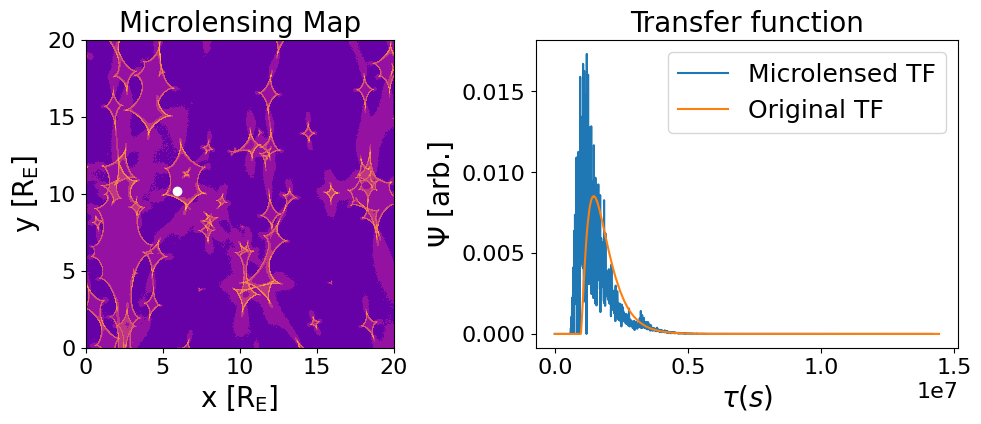

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].contourf(X, Y, np.log10(MagMap.magnification_array), cmap="plasma")
ax[0].plot(x_po / scale, y_po / scale, "o", color="white", label='Source Position')
ax[0].set_xlabel(r"x [R$_{\rm E}$]")
ax[0].set_ylabel(r"y [R$_{\rm E}$]")
ax[0].set_title("Microlensing Map")
ax[0].set_aspect(1)

ax[1].plot(xaxis, microlensed_response[:], label='Microlensed TF')
ax[1].plot(xaxis2, disk_transfer_function[:], label='Original TF')
ax[1].set_title("Transfer function")
ax[1].set_xlabel(r"$\tau (s)$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")
ax[1].legend()
plt.show()


In [ ]:
plt.plot(delays[:, delays.shape[0]//2+4])

In [ ]:
mag_map_num_pix

In [ ]:
Disk.g_array.shape

In [ ]:
plt.imshow(delays)
plt.colorbar()

1. if you increase/decrease the resolution of the accretion disk by a factor of 10, and this impacts the shift
2. change units of x axis --> physical time units

Note to future padma:
`MagMap.calculate_microlensed_transfer_function` 

--> `util.calculate_microlensed_transfer_function` 

--> calls `construct_accretion_disk_transfer_function` to obtain disk response and 

--> calls `util.perform_microlensing_convolution`

In [ ]:
plt.plot(microlensed_response)


In [ ]:
# its noisy bc of resolution of microlensing map - if you increase Rg, this might get better

#### How to fix this slight offset?

Here, the left plot shows the magnification map with a white dot located where the transfer function is calculated at. In right is the response in blue, with the unmicrolensed case in orange. Microlensing may have a significant impact.

Note that scaling the pixels of the accretion disk image to the pixel sizes of the magnification map may introduce a slight shift in the transfer function.



### DRW Light Curve

The next couple functions are a few conveinence functions, MakeDRW creates a generic damped random walk signal given parameters:

`t_max`, the maximum time we calculate to

`delta_t`, the time step between points

`SF_inf`, the asymptotic structure function value

`tau`, the characteristic time scale

In [ ]:
t_max = 10 * 365 # years, by default
delta_t = 1  # days, by default
SF_inf = 20
tau = 30  # Days, by default
np.random.seed(3)

DRW = util.generate_drw_signal(length_of_light_curve=t_max, time_step=delta_t, sf_infinity=SF_inf,tau_drw=tau)
DRW2 = util.generate_drw_signal(t_max, delta_t, SF_inf, tau*4)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DRW, alpha=0.5, label='$\\tau$=30')
ax.plot(DRW2, color='b',label='$\\tau$=120')
ax.set_xlabel("Time [days]")
ax.set_ylabel("DRW [arb.]")
# plt.grid(np.linspace(0,len(DRW),120))
plt.legend()
plt.show()

In [ ]:
timestamps = np.linspace(0, t_max, int(t_max / delta_t) + 1)

new_timestamps, signal_convolved = util.convolve_signal_with_transfer_function(
    mass_exponent=8.0,
    driving_signal=DRW,
    transfer_function=basic_transfer_function,
    initial_time_axis=timestamps,
)


new_timestamps2, signal_convolved2 = util.convolve_signal_with_transfer_function(
    mass_exponent=8.0,
    driving_signal=DRW,
    transfer_function=microlensed_response,
    initial_time_axis=timestamps,
)


fig, ax = plt.subplots(4, 1, figsize=(10, 13))
# ax.plot(timestamps, DRW, label="Driving signal", lw=3, color='k')
ax[0].plot(microlensed_response, label='Microlensed TF')
ax[0].plot(basic_transfer_function, label='Original TF')
ax[0].set_title("Transfer function")
ax[1].plot(DRW, alpha=0.5, label='$\\tau$=30')

ax[1].set_title("Original DRW Signal")
ax[2].plot(
    new_timestamps, signal_convolved / np.std(signal_convolved), label="Signal*TF response", lw=1, color='b'
)
ax[2].plot(
    new_timestamps2, signal_convolved2/ np.std(signal_convolved2), label="Signal*MicrolensingTF response",alpha=1,
    ls='--',lw=1, color='orange'
)
# # Zoom in to show impact
# ax[1].set_xlim(2000, 2050)
# ax[2].set_xlim(2000, 2500)
# ax[2].set_xlim(2000, 2500)

# ax[3].set_xlim(2000, 2500)
ax[2].legend(loc=(0.,1), ncols=2)
ax[2].set_ylabel("Flux (normalized)")
ax[3].set_xlabel("Time [days]")
ax[3].plot((signal_convolved[:] / np.std(signal_convolved[:])) - (signal_convolved2/ np.std(signal_convolved2)))
ax[3].set_ylabel("Residuals")
plt.show()

In [ ]:
# plot transfer function in days

Now let's take the source plane signal and convolve it with the two transfer functions above, then bring into the observer frame.

In [ ]:
timestamps = np.linspace(0, 3653, 3653)
signal_w_ML = QMF.Convolve_TF_With_Signal(DRW, mag_tf, timestamps)
signal_no_ML = QMF.Convolve_TF_With_Signal(DRW, basic_transfer_function, timestamps)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(signal_no_ML[1000:1500], label="Regular TF")  # Zoom in to show impact
ax.plot(signal_w_ML[1000:1500], label="Microlensed TF")
ax.legend()
plt.show()

Our FlatDisk object is the current supported accretion disk model. Plans to extend this to arbitrarily puffy disks will be acted upon in the future. If Sim5 is installed, a helper function to create all maps through ray tracing around the central black hole is included in QMF, where the outputs may be fed directly into the FlatDisk object.

We will go through the arguments for this helper function:

mass_exp, log_10(M_BH/M_sun)

redshift, source redshift

numGRs, number of gravitational radii to calculate the accretion disk out to RADIALLY

inc_ang, the inclination angle of the disk in degrees

resolution, the amount of pixels used in calculating the images along each axis

spin, the dimensionless spin parameter of the central black hole

disk_acc, the amount of material accreted

temp_beta, the strength of the disk wind (or asymptotic temperature slope if genericbeta is True)

coronaheight, the z position of the irradiating corona in gravitational radii

albedo, the reflectivity of the disk with respect to the x-ray heating source. 0 is perfect absorption, while 1 is perfect reflection (therefore, no contribution)

eta, the x-ray source efficiency coefficient. Determines how strong the illuminating source is with respect to the bolometric luminosity.

genericbeta, a toggle to use if you want temp_beta to represent the asymptotic temperature slope

eddingtons, if given as a fraction, the required accretion rate will be calculated to meet this eddington ratio and used instead of the default value for disk_acc.



Ray tracing may be time consuming, and is known to be the longest part of the simulation process. We therefore defer using this function right now and opt to use a pre-traced file.

In [ ]:
filepath = example_disk_path  #path to fits file
with fits.open(filepath) as f:
    m1 = f[0].data
    m2 = f[1].data
    m3 = f[2].data
    m4 = f[3].data


mexp = f[0].header['mass']
zq = f[0].header['zq']
spin = f[0].header['spin']
inc_ang = f[0].header['inc_ang']
c_height = f[0].header['c_height']
beta = f[0].header['beta']
if 'numGRs' in f[0].header:
    numGRs = f[0].header['numGRs']
else:
    numGRs = 1000

AccDisk = Amoeba.FlatDisk(mexp, zq, numGRs, inc_ang, c_height, m1, m2, m3, m4, spin=spin)



Now that a proper accretion disk is loaded in memory, we can do things more simply. Let's make the surface intensity map with the method "MakeSurfaceIntensityMap".

We require an argument of the wavelength.

Additionally, toggling returnwavelengths to True will give a map of the locally emitted wavelengths which get shifted into the observers wavelength.

In [ ]:
wavelen = 1000
intensities, wavelengths = AccDisk.MakeSurfaceIntensityMap(wavelen, returnwavelengths=True)
timelags = AccDisk.MakeTimeDelayMap(unit='hours', jitters=False)
contours = [10, 20, 50, 100, 200]
size = 100
center = np.size(m1, 0) // 2

xaxis = np.linspace(-numGRs, numGRs, np.size(m1, 0))
yaxis = xaxis.copy()
zoomaxis = np.linspace(-size, size, 2*size)
X, Y = np.meshgrid(xaxis, yaxis, indexing='ij')
Xzoom, Yzoom = np.meshgrid(zoomaxis, zoomaxis, indexing='ij')
fig, ax = plt.subplots(1, 2, figsize=(16,6))
c1 = ax[0].contourf(Xzoom, Yzoom, intensities[center-size:center+size, center-size:center+size])
td1 = ax[0].contour(Xzoom, Yzoom, timelags[center-size:center+size, center-size:center+size], contours, colors='white')
plt.clabel(td1, inline=1, fontsize=16)
c2 = ax[1].contourf(Xzoom, Yzoom, wavelengths[center-size:center+size, center-size:center+size], 50, cmap='RdBu')
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.colorbar(c1, ax=ax[0], label="Surface flux density\n "+r"[W sr$^{-1}$ m$^{-3}$]")
plt.colorbar(c2, ax=ax[1], label=r"$\lambda$ [nm]")
ax[0].set_xlabel(r"x [$R_{g}$]")
ax[1].set_xlabel(r"x [$R_{g}$]")
ax[0].set_ylabel(r"y [$R_{g}$]")
ax[1].set_ylabel(r"y [$R_{g}$]")
plt.subplots_adjust(wspace=0.5)
plt.show()

In the first plot, we have zoomed in to highlight the asymmetry. In the second plot, we show the wavelengths across the disk which get shifted into the observed wavelength.

It is shown that a surface intensity map can be asymmetric especially near the black hole, and the calculated wavelengths are non-trivial across the whole map.

The methods MakeDBDTMap, MakeTimeDelayMap, and MakeDTDLxMap are more straight-forward ways to run the functions that construct the transfer function which we saw earlier. Arguments are fewer, as many are passed in directly from the initialization of the object. Many initialized values can still be overridden.

We can look at ConstructDiskTransferFunction next, which combines the above methods that were just glossed over. Arguments are:

wavelength, the wavelength in the observers frame of reference in nanometers

coronaheight, if a different lamp post is desired, this is the z position of the irradiating source.

axisoffset/angleoffset is the (r, phi) position of this irradiating source

maxlengthoverride, a tool to predetermine the longest time lag you calculae out to

units, the units of the time lag axis on the constructed transfer function

albedo, reflectivity of the accretion disk. 

smooth, toggle to use a smoothing kernel on the transfer function or not

fixedwindowlength, user specified smoothing kernel size, otherwise it will be determined automatically

In [ ]:
wavelen1 = 500
wavelen2 = 700
wavelen3 = 900
wavelen4 = 1100

transfer_function1 = AccDisk.ConstructDiskTransferFunction(wavelen1, scaleratio=5)
transfer_function2 = AccDisk.ConstructDiskTransferFunction(wavelen2, scaleratio=5)
transfer_function3 = AccDisk.ConstructDiskTransferFunction(wavelen3, scaleratio=5)
transfer_function4 = AccDisk.ConstructDiskTransferFunction(wavelen4, scaleratio=5)

mean1 = np.sum(np.linspace(0, len(transfer_function1), len(transfer_function1)) * transfer_function1)
mean2 = np.sum(np.linspace(0, len(transfer_function2), len(transfer_function2)) * transfer_function2)
mean3 = np.sum(np.linspace(0, len(transfer_function3), len(transfer_function3)) * transfer_function3)
mean4 = np.sum(np.linspace(0, len(transfer_function4), len(transfer_function4)) * transfer_function4)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(transfer_function1, label=r"$\lambda_{1}$ = "+str(wavelen1)+" nm")
ax.plot(transfer_function2, label=r"$\lambda_{2}$ = "+str(wavelen2)+" nm")
ax.plot(transfer_function3, label=r"$\lambda_{3}$ = "+str(wavelen3)+" nm")
ax.plot(transfer_function4, label=r"$\lambda_{4}$ = "+str(wavelen4)+" nm")

ax.text(0.2 * len(transfer_function1), 0.9 * np.max(transfer_function1), r"$\bar{\tau}_{1}$ = "+str(mean1)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.85 * np.max(transfer_function1), r"$\bar{\tau}_{2}$ = "+str(mean2)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.8 * np.max(transfer_function1), r"$\bar{\tau}_{3}$ = "+str(mean3)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.75 * np.max(transfer_function1), r"$\bar{\tau}_{4}$ = "+str(mean4)[:4]+" hours", fontsize=16)

ax.legend()
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel(r"$\Psi$ [Arb.]")

plt.show()

We have plotted here the derived transfer functions for four wavelengths, and the mean time delays.

Longer wavelengths will generally have wider transfer functions and therefore longer mean time lags as expected.

## Magnification Map

The MagnificationMap object is used to store and use a magnification map due to microlensing. In creating this object, the following arguments are needed:

redshift_quasar, the redshift of the source

redshift_lens, the redshift of the microlenses (which must be less than the redshift of the source)

file_name, the file which contains the magnification map. This can be a .fits file or a .dat, or a numpy array of values. If downloaded from the GERLUMPH database, it will come as a .dat file, which will be converted into a ray map of appropriate size. It's recommended to store this as a .fits file for future use to speed up the conversion process. Amoeba assumes this file will be ray counts per pixel, so a conversion to magnification will occur next.

convergence, the total convergence of the microlensing map (Kappa)

shear, the shear of the microlensing map (Gamma)

m_lens, the assumed average microlens mass

n_einstein, the number of Einstein radii along each side of the magnification map. A square map is assumed.

Om0, OmL, H0: the cosmological parameters of the flat LambdaCDM model

ismagmap, a toggle to tell Amoeba that the input map is actually an array of magnifications instead of ray counts. This stops the conversion of ray counts to magnification values.

name, a name space


In [ ]:
mag_map_path = example_mag_map_path

with fits.open(mag_map_path) as f:
    mag_map = f[0].data

MagMap = Amoeba.MagnificationMap(0.1, 0.05, mag_map, 0.3, 0.3, ismagmap=True)

The magnification map of the MagnificationMap object can be referenced directly by MagnificationMap.mag_map

The pixel size is stored as MagnificationMap.px_size



One primary method used will be Convolve, which calculates the convolution of an accretion disk with the magnification map. It takes the following arguments:

Disk, the accretion disk object

obs_wavelength, the observed wavelength. This value gets redshifted to the local wavelength at the source plane, then the surface brightness map is calculated for that wavelength (which further considers Doppler shifting and gravitational redshift).

rotation, a degree rotation in the source plane

This convolution can be stored in the object ConvolvedMap, to facilitate creating microlensing light curves

In [ ]:
filepath = example_disk_path  #path to fits file
with fits.open(filepath) as f:
    m1 = f[0].data
    m2 = f[1].data
    m3 = f[2].data
    m4 = f[3].data

f[0].header
mexp = f[0].header['mass']
zq = f[0].header['zq']
spin = f[0].header['spin']
inc_ang = f[0].header['inc_ang']
c_height = f[0].header['c_height']
beta = f[0].header['beta']
numGRs = 1000

AccDisk = Amoeba.FlatDisk(mexp, zq, numGRs, inc_ang, c_height, m1, m2, m3, m4, spin=spin)

In [ ]:
convolution, px_size, px_shift = MagMap.Convolve(AccDisk, 500, rotation=0)
Conv_Map = Amoeba.ConvolvedMap(MagMap, AccDisk, 500, rotation=0)

fig, ax = plt.subplots(1,2, figsize=(14,6))

contours1 = ax[0].contourf(convolution)
contours2 = ax[1].contourf(Conv_Map.mag_map)
plt.colorbar(contours1, ax=ax[0])
plt.colorbar(contours2, ax=ax[1])
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[0].set_xlabel(r"x [px]")
ax[1].set_xlabel(r"x [px]")
ax[0].set_ylabel(r"y [px]")
plt.show()

There is no notable difference between the two, however the pixel shift is stored within the ConvolvedMap. This value is inportant for accurately pulling light curves!

In [ ]:
print(MagMap.px_shift)
print(px_shift)
print(Conv_Map.px_shift)

However, this also means the convolved map is now locked at a certain observed wavelength. 

ConvolvedMap is a child of MagnificationMap, so it has the PullValue and PullLightCurve methods.

PullValue is generally not useful by itself, but PullLightCurve uses this method to extract the light curve. It has the following arguments:

vtrans, the transverse velocity in the source plane. This is expressed as km/s, where typical values range up to ~500 km/s. Some special cases like the Einstein Cross (Q2237+0305) may have significantly higher transverse velocities.

time, the length of the light curve measured in years

x_start, y_start: the starting position of the light curve in pixels. If left as None, a random starting point will be selected such that it will not cross into the convolution artifacts found near the edges.

phi_angle, the direction of travel in the source plane measured in degrees

In [ ]:
x = 4000   # pixels
y = 7000   # pixels
phi = 72   # degrees
vel = 400  # km/s
time = 20  # years

np.random.seed(21)

LC_specified = Conv_Map.PullLightCurve(vel, time, x_start=x, y_start=y, phi_angle=phi)
LC_random = Conv_Map.PullLightCurve(vel, time)

fig, ax = plt.subplots(figsize=(10, 6))
timeaxis = np.linspace(0, time, len(LC_random))
ax.plot(timeaxis, LC_random/np.max(LC_random), label='random LC')
ax.plot(timeaxis, LC_specified/np.max(LC_specified), label='specific LC')
ax.set_xlabel("time [years]")
ax.set_ylabel("obs. flux [arb.]")
ax.legend()
plt.show()

There are units involved in extracting these light curves, but the scaling depends on the size of the instrument used and the total size of the accretion disk image. It is safe to normalize them to use arbitrarily in studies.

The final method in the MagnificationMap object is GenerateMicrolensedResponse, which should be called with the MagnificationMap object only and not the ConvolvedMap (else there will be a double convolution). This method computes a microlensed transfer function using the QMF function MicrolensedResponse as was done previously.

The GenerateMicrolensedResponse takes the following arguments:

Disk, the accretion disk object

wavelength, the observed wavelength

coronaheight, the z position of the flaring lamp post which the transfer function will be constructed with respect to. If left "None", this will keep the lamp post position of the accretion disk object. Modeling other sources of irradiation can be done as well.

rotation, the degree rotation on the source plane. This is sometimes refered to as the position angle on the microlensing map.

x_position, y_position: the (x, y) coordinates in pixels on the magnification map. If left "None", this will randomly choose a spot which will remain fully on the magnification map, if possible.

axisoffset, angleoffset: the (r, phi) position of the flaring lamp post with respect to the accretion disk's axis of symmetry, in units $R_{\rm g}$ and degrees.

unit, the time units of the transfer function

smooth, toggle to use a smoothing kernel on the transfer function after it's calculated

returnmaps, toggle to return the maps prior to calculating the transfer function

In [ ]:
wavelength = 500
seednum = 40
np.random.seed(seednum)
TransferFunction = MagMap.GenerateMicrolensedResponse(AccDisk, wavelength)
np.random.seed(seednum)
TransferFunctionSmooth = MagMap.GenerateMicrolensedResponse(AccDisk, wavelength, smooth=True)
np.random.seed(seednum)
TransferFunctionUpscaled = MagMap.GenerateMicrolensedResponse(AccDisk, wavelength, scaleratio=10)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(TransferFunction, label="pre-smoothing")
ax.plot(TransferFunctionSmooth, label='post-smoothing')
ax.plot(TransferFunctionUpscaled, label='upscaling')
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel(r"$\Psi$ [arb.]")
ax.legend()
plt.show()

Due to the finite size of the smoothing kernel and the abrupt start of the transfer function, it may shift the peak and mean value slightly. However, we can show that upscaling keeps the expected $\tau$.

In [ ]:
meanTF = np.sum(np.linspace(0, len(TransferFunction), len(TransferFunction))*TransferFunction)
meansmoothTF = np.sum(np.linspace(0, len(TransferFunctionSmooth), len(TransferFunctionSmooth))*TransferFunctionSmooth)
meanupscaledTF = np.sum(np.linspace(0, len(TransferFunctionUpscaled), len(TransferFunctionUpscaled))*TransferFunctionUpscaled)

print(r"Without smoothing, tau_avg = "+str(meanTF)[:5]+" hours")
print(r"With smoothing, tau_avg = "+str(meansmoothTF)[:5]+" hours")
print(r"With upscaling, tau_avg = "+str(meanupscaledTF)[:5]+" hours")


This notebook will be extended as features are added, thank you for taking the time to try Amoeba out!

In [ ]:
time_final = supertime.time()
print("Total time elapsed =", str(time_final-time_initial)[:6], "seconds")